# Loading packages

In [138]:
import io
import numpy as np
import _pickle as pickle
from scipy import spatial


# Utils

In [139]:
def get_pairs(pairs_file):
  """
  read pairs file and returns list of tuples (src_lang, tgt_lang)
  """
  pairs = [] #0 en , 1 en
  with open(pairs_file, "r") as fp:
    for i in fp.readlines():
      tmp = i.split()
      pairs.append((tmp[0], tmp[1]))
  return pairs


def uniq_values(pairs,entery):
  """
  reads list of pairs and return list of tuples with unique words in src_lang
  """
  check_val = set()      #Check Flag
  res = []
  for i in pairs:
    if i[entery] not in check_val:
        res.append(i)
        check_val.add(i[entery])
  return check_val,res


In [140]:
def load_matrices(train,src_dict,trg_dict):
  """
  building X,Y matrices to solve Y = XW
  """
  matrix_X = []
  matrix_Y = []

  _,temp_pairs = uniq_values(train,0)

  resultat_pairs =[]
  for elem in temp_pairs:
    if ((elem[0] in src_dict.keys()) and (elem[1] in trg_dict.keys())):
      resultat_pairs.append((elem[0],elem[1]))

  for elem in resultat_pairs:
    matrix_X.append(src_dict[elem[0]])
    matrix_Y.append(trg_dict[elem[1]])

  return np.array(matrix_X), np.array(matrix_Y), resultat_pairs


In [141]:
#SVD
def Orthogonal_trans(matX, matY):
  U,Sigma,VT = np.linalg.svd(matX.T.dot(matY))
  res_matrix = U.dot(VT)
  return res_matrix

#least square
def Linear_trans(matX, matY):
  return np.linalg.lstsq(matX, matY)[0]


In [142]:
def get_knn(W, word, words_pairs, src_dict, tgt_emb, K=5):
    pred_vec = src_dict[word]
    word_emb = pred_vec.dot(W)

    #scores_tst=[]
    #for i in range(tgt_emb.shape[0]):
    #  scores_tst.append(1 - spatial.distance.cosine(tgt_emb[i],word_emb))
    #scores_tst = np.array(scores_tst)

    scores=(tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[::-1][:K]

    #k_best = scores_tst.argsort()[::-1][:K]
    predict_words=[]
    predict_scores= []
    for i, idx in enumerate(k_best):
        predic = words_pairs[idx][1]
        predict_words.append(predic)
        predict_scores.append(scores[idx])
        #predict_scores.append(scores_tst[idx])
        #print('%.4f - %s' % (scores_tst[idx], predic))
    return predict_words,predict_scores

In [143]:
def load_testpairs(test_p, src_dict, tgt_dict):
  pairs_tst = []
  for elem in test_p:
    if ((elem[0] in src_dict.keys()) and (elem[1] in tgt_dict.keys())):
      pairs_tst.append(elem)
  return pairs_tst

In [144]:
def load_matrices_test(train,src_dict,trg_dict):
  """
  building X,Y matrices to solve Y = XW
  """
  matrix_X = []
  matrix_Y = []


  for elem in train:
    matrix_X.append(src_dict[elem[0]])
    matrix_Y.append(trg_dict[elem[1]])

  return np.array(matrix_X), np.array(matrix_Y)

In [145]:

def plot_similar_word(W, src_words, src_dict, tgt_words, tgt_dict, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        pred_vec = src_dict[sw]
        pred_word = sw+"(TR)"
        Y.append(pred_vec)
        word_labels.append(sw)

        Y.append(pred_vec.dot(W))
        word_labels.append(pred_word)

    for tw in tgt_words:
        Y.append(tgt_dict[tw])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

  
    
    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        if label in src_words:
          color = 'blue'
        elif label in tgt_words:
          color = 'red'
        else:
          color = 'orange'

        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=12,
                     color=color, weight='bold')

    D_id_color = {'Source': u'blue', 'Target': u'red', 'Translation': u'orange'}  
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in D_id_color.values()]
    
    plt.legend(markers, D_id_color.keys(), numpoints=1)
    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

# Translation FR -> EN

In [ ]:
#Downloading Train-Test files
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/fr-en.0-5000.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/fr-en.5000-6500.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/fr-en.txt

In [146]:
#Loading english and french embeddings

file_to_read = open("/content/drive/MyDrive/data1/fr_dict.pkl", "rb")

fr_dict = pickle.load(file_to_read)

file_to_read = open("/content/drive/MyDrive/data1/en_dict.pkl", "rb")

en_dict = pickle.load(file_to_read)

In [147]:
print(len(fr_dict.keys()),len(en_dict.keys()))

61934 63069


In [148]:
#loading train-test pairs
full_pairs = get_pairs("/content/fr-en.txt")
train_pairs = get_pairs("/content/fr-en.0-5000.txt")
test_pairs = get_pairs("/content/fr-en.5000-6500.txt")

print(train_pairs)

[('des', 'of'), ('les', 'the'), ('est', 'is'), ('est', 'east'), ('une', 'a'), ('une', 'an'), ('une', 'one'), ('dans', 'in'), ('catégorie', 'category'), ('par', 'by'), ('pour', 'for'), ('sur', 'on'), ('qui', 'who'), ('que', 'that'), ('avec', 'with'), ('son', 'sound'), ('son', 'his'), ('son', 'its'), ('plus', 'plus'), ('plus', 'more'), ('pas', 'not'), ('pas', 'no'), ('sont', 'are'), ('elle', 'she'), ('elle', 'elle'), ('elle', 'it'), ('aux', 'to'), ('été', 'summer'), ('avancement', 'advancement'), ('avancement', 'progress'), ('comme', 'as'), ('comme', 'like'), ('mais', 'but'), ('cette', 'this'), ('pop', 'pops'), ('pop', 'pop'), ('deux', 'two'), ('ses', 'his'), ('ses', 'ses'), ('ses', 'its'), ('naissance', 'naissance'), ('naissance', 'born'), ('naissance', 'birth'), ('aussi', 'also'), ('france', 'france'), ('saint', 'holy'), ('saint', 'saint'), ('après', 'after'), ('fait', 'made'), ('fait', 'done'), ('notes', 'notes'), ('entre', 'between'), ('sous', 'under'), ('même', 'even'), ('même', 'sa

In [149]:
X, Y, src_tgt_pairs = load_matrices(train_pairs,fr_dict,en_dict)


print('X: ',X.shape, ' Y: ',Y.shape)

X:  (4923, 300)  Y:  (4923, 300)


In [150]:
svd_trans_fr_en = Orthogonal_trans(X, Y)
svd_trans_fr_en.shape

(300, 300)

In [151]:
lsq_trans_fr_en = Linear_trans(X, Y)
lsq_trans_fr_en.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


(300, 300)

In [152]:
#using linear transformation
word = "ville"
pw,ps = get_knn(lsq_trans_fr_en, word, src_tgt_pairs, fr_dict, Y, K=5)
print("source word (FR) :", word)
print("target language (EN) :")
for i, pred_wrd in enumerate(pw):
        print('%.4f - %s' % (ps[i], pred_wrd))

source word (FR) : ville
target language (EN) :
0.8267 - city
0.7615 - town
0.6046 - village
0.6022 - outskirts
0.5594 - neighborhood


In [154]:
#using orthogonal transformation
word = "ville"
pw,ps = get_knn(svd_trans_fr_en, word, src_tgt_pairs, fr_dict, Y, K=5)
print("source word (FR) :", word)
print("target language (EN) :")
for i, pred_wrd in enumerate(pw):
        print('%.4f - %s' % (ps[i], pred_wrd))

source word (FR) : ville
target language (EN) :
0.7348 - city
0.6998 - town
0.5606 - outskirts
0.5449 - village
0.5083 - streets


In [155]:
#loading test set
pairs_test = load_testpairs( test_pairs, fr_dict, en_dict)
X_test, Y_test = load_matrices_test(pairs_test,fr_dict,en_dict)

print(pairs_test)

[('kiev', 'kyiv'), ('kiev', 'kiev'), ('sac', 'bag'), ('flûte', 'flute'), ('arabie', 'arabia'), ('plaques', 'plates'), ('plaques', 'plaques'), ('concernés', 'concerned'), ('dispositions', 'provisions'), ('cratère', 'crater'), ('johannes', 'johannes'), ('annexe', 'appendix'), ('annexe', 'annex'), ('hard', 'hardcore'), ('hard', 'hard'), ('ralph', 'ralph'), ('leo', 'leo'), ('traction', 'traction'), ('traction', 'tensile'), ('désolé', 'sorry'), ('essor', 'booming'), ('géologie', 'geology'), ('parlé', 'spoken'), ('parlé', 'talked'), ('harvard', 'harvard'), ('chasseur', 'fighter'), ('chasseur', 'hunter'), ('chasseur', 'chasseur'), ('vend', 'sells'), ('java', 'java'), ('sénateurs', 'senators'), ('signer', 'signing'), ('signer', 'sign'), ('trou', 'hole'), ('trou', 'trou'), ('courrier', 'courier'), ('courrier', 'mail'), ('permanent', 'permanent'), ('nulle', 'null'), ('matériau', 'material'), ('neil', 'neil'), ('copa', 'copa'), ('ron', 'ron'), ('sondage', 'poll'), ('sondage', 'survey'), ('moon', 

In [156]:

def topK(W, test_p, Y_mat, k_n):
  accuracy =0.0
  for tup in test_p:
    pred_w,pred_s = get_knn(W, tup[0], test_p, fr_dict, Y_mat, K=k_n)
    if tup[1] in pred_w:
      accuracy=accuracy+1 
  accuracy= accuracy/len(test_p)
  return accuracy

In [157]:
#Train accuracy
#Top5
top5 = topK(lsq_trans_fr_en,src_tgt_pairs, Y, 5)
print("top5 :",top5)
train_top5 = topK(svd_trans_fr_en,src_tgt_pairs, Y, 5)
print("top5 :",train_top5)

#Top1
top1 = topK(lsq_trans_fr_en,src_tgt_pairs, Y, 1)
print("top1 :",top1)
train_top1 = topK(svd_trans_fr_en,src_tgt_pairs, Y, 1)
print("top1 :",train_top1)

#Top10
top10 = topK(lsq_trans_fr_en,src_tgt_pairs, Y, 10)
print("top10 :",top10)
train_top10 = topK(svd_trans_fr_en,src_tgt_pairs, Y, 10)
print("top10 :",train_top10)

top5 : 0.8679666869794841
top5 : 0.883810684541946
top1 : 0.7393865529148893
top1 : 0.7568555758683729
top10 : 0.9085923217550275
top10 : 0.9173268332317692


In [158]:
#Test accuracy 

#Top5
top5 = topK(lsq_trans_fr_en, pairs_test, Y_test, 5)
print("top5 :",top5)
test_top5 = topK(svd_trans_fr_en, pairs_test, Y_test, 5)
print("top5 :",test_top5)

#Top1
top1 = topK(lsq_trans_fr_en, pairs_test, Y_test, 1)
print("top1 :",top1)
test_top1 = topK(svd_trans_fr_en, pairs_test, Y_test, 1)
print("top1 :",test_top1)

#Top10
top10 = topK(lsq_trans_fr_en, pairs_test, Y_test, 10)
print("top10 :",top10)
test_top10 = topK(svd_trans_fr_en, pairs_test, Y_test, 10)
print("top10 :",test_top10)

top5 : 0.8224589436307146
top5 : 0.8393253439857967
top1 : 0.5246338215712384
top1 : 0.5392809587217043
top10 : 0.877496671105193
top10 : 0.8934753661784287


In [159]:
#Visualisation
import matplotlib.pyplot as plt

In [160]:
labels = [ 'Top 1', 'TOP 5', 'Top10']
train_acc = [100*train_top1, 100*train_top5, 100*train_top10]
test_acc = [100*test_top1, 100*test_top5, 100*test_top10]


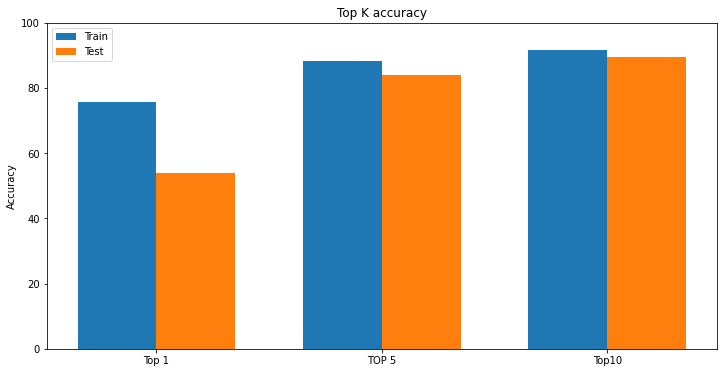

In [161]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, train_acc, width, label='Train')
ax.bar(x + width/2, test_acc, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Top K accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.ylim(0,100)
plt.show()

In [162]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  
pca.fit(np.vstack([X, Y]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())



Variance explained: 0.10


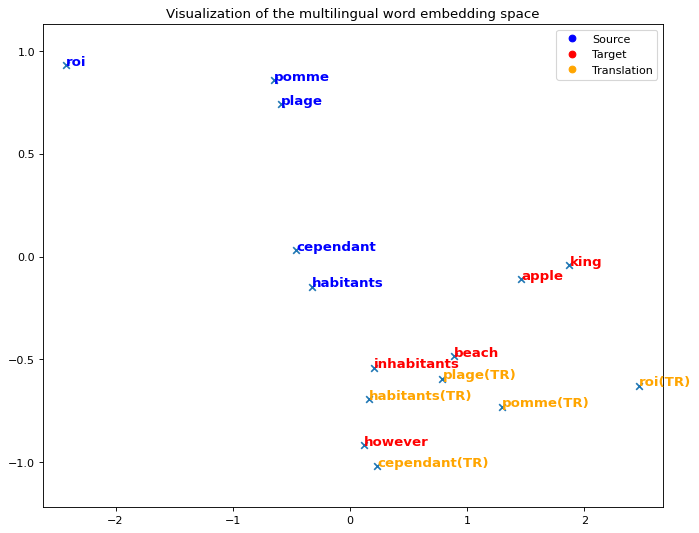

In [163]:

src_words = ['pomme','plage','roi', 'habitants', 'cependant']
tgt_words = ['apple','beach','king','inhabitants',  u'however']



plot_similar_word(svd_trans_fr_en, src_words, fr_dict, tgt_words, en_dict, pca)

# Translation EN -> FR

In [ ]:
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.0-5000.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.5000-6500.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.txt

In [165]:
#Loading english and french embeddings

file_to_read = open("/content/drive/MyDrive/data1/fr_dict1.pkl", "rb")

fr_dict = pickle.load(file_to_read)

file_to_read = open("/content/drive/MyDrive/data1/en_dict1.pkl", "rb")

en_dict = pickle.load(file_to_read)

In [166]:
print(len(fr_dict.keys()),len(en_dict.keys()))

61947 63021


In [167]:
#loading train-test pairs
full_pairs = get_pairs("/content/en-fr.txt")
train_pairs = get_pairs("/content/en-fr.0-5000.txt")
test_pairs = get_pairs("/content/en-fr.5000-6500.txt")

print(train_pairs)

[('the', 'le'), ('the', 'les'), ('the', 'la'), ('and', 'et'), ('was', 'fut'), ('was', 'etait'), ('was', 'était'), ('for', 'pour'), ('that', 'que'), ('that', 'cela'), ('with', 'avec'), ('from', 'du'), ('from', 'de'), ('from', 'depuis'), ('this', 'ceci'), ('this', 'cet'), ('this', 'cette'), ('this', 'cela'), ('this', 'ce'), ('utc', 'utc'), ('utc', 'tuc'), ('his', 'sa'), ('his', 'his'), ('his', 'ses'), ('his', 'son'), ('not', 'not'), ('not', 'non'), ('not', 'pas'), ('are', 'sont'), ('talk', 'parler'), ('talk', 'parle'), ('talk', 'talk'), ('talk', 'parlez'), ('which', 'lesquels'), ('which', 'laquelle'), ('which', 'lequel'), ('also', 'également'), ('also', 'aussi'), ('also', 'egalement'), ('were', 'étaient'), ('but', 'mais'), ('have', 'avoir'), ('have', 'ont'), ('one', 'un'), ('one', 'une'), ('one', 'one'), ('new', 'nouveau'), ('new', 'nouvelle'), ('new', 'nouvelles'), ('new', 'nouveaux'), ('new', 'nouveautés'), ('first', 'première'), ('first', 'premières'), ('first', 'premier'), ('first', 

In [168]:
X, Y, src_tgt_pairs = load_matrices(train_pairs,en_dict,fr_dict)


print('X: ',X.shape, ' Y: ',Y.shape)

X:  (4984, 300)  Y:  (4984, 300)


In [169]:
svd_trans_en_fr = Orthogonal_trans(X, Y)
svd_trans_en_fr.shape

(300, 300)

In [170]:
lsq_trans_en_fr = Linear_trans(X, Y)
lsq_trans_en_fr.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


(300, 300)

In [171]:
#using linear transformation
word = "town"
pw,ps = get_knn(lsq_trans_en_fr, word, src_tgt_pairs, en_dict, Y, K=5)
print("source word (EN) :", word)
print("target language (FR) :")
for i, pred_wrd in enumerate(pw):
        print('%.4f - %s' % (ps[i], pred_wrd))

source word (EN) : town
target language (FR) :
0.7886 - ville
0.7886 - ville
0.7632 - village
0.6257 - région
0.6257 - région


In [172]:
#using orthogonal transformation
word = "town"
pw,ps = get_knn(svd_trans_en_fr, word, src_tgt_pairs, en_dict, Y, K=5)
print("source word (EN) :", word)
print("target language (FR) :")
for i, pred_wrd in enumerate(pw):
        print('%.4f - %s' % (ps[i], pred_wrd))

source word (EN) : town
target language (FR) :
0.7259 - ville
0.7259 - ville
0.7094 - village
0.5621 - faubourg
0.5605 - district


In [173]:
#loading test set
pairs_test = load_testpairs( test_pairs, en_dict, fr_dict)
X_test, Y_test = load_matrices_test(pairs_test,en_dict, fr_dict)

print(pairs_test)

[('torpedo', 'torpille'), ('torpedo', 'torpilles'), ('giovanni', 'giovanni'), ('chat', 'discuter'), ('chat', 'discussion'), ('chat', 'causerie'), ('chat', 'bavardage'), ('chat', 'chat'), ('catholics', 'catholiques'), ('herald', 'herald'), ('chuck', 'chuck'), ('pit', 'pit'), ('pit', 'fosse'), ('supplied', 'approvisionné'), ('supplied', 'fournis'), ('supplied', 'fournies'), ('supplied', 'fourni'), ('supplied', 'fournie'), ('optional', 'optionnelles'), ('optional', 'facultatif'), ('optional', 'facultative'), ('optional', 'optionnel'), ('optional', 'facultatives'), ('garrison', 'garrison'), ('garrison', 'garnison'), ('sprint', 'sprint'), ('exile', 'exilé'), ('exile', 'exil'), ('exile', 'exilés'), ('surprised', 'surprise'), ('surprised', 'surpris'), ('surprised', 'étonné'), ('surprised', 'étonnée'), ('achievements', 'réussites'), ('achievements', 'accomplissements'), ('achievements', 'réalisations'), ('biblical', 'biblique'), ('biblical', 'bibliques'), ('rebels', 'rebelles'), ('denis', 'den

In [174]:

def topK(W, test_p, Y_mat, k_n):
  accuracy =0.0
  for tup in test_p:
    pred_w,pred_s = get_knn(W, tup[0], test_p, en_dict, Y_mat, K=k_n)
    if tup[1] in pred_w:
      accuracy=accuracy+1 
  accuracy= accuracy/len(test_p)
  return accuracy

In [175]:
#Train accuracy
#Top5
top5 = topK(lsq_trans_en_fr,src_tgt_pairs, Y, 5)
print("top5 :",top5)
train_top5 = topK(svd_trans_en_fr,src_tgt_pairs, Y, 5)
print("top5 :",train_top5)

#Top1
top1 = topK(lsq_trans_en_fr,src_tgt_pairs, Y, 1)
print("top1 :",top1)
train_top1 = topK(svd_trans_en_fr,src_tgt_pairs, Y, 1)
print("top1 :",train_top1)

#Top10
top10 = topK(lsq_trans_en_fr,src_tgt_pairs, Y, 10)
print("top10 :",top10)
train_top10 = topK(svd_trans_en_fr,src_tgt_pairs, Y, 10)
print("top10 :",train_top10)

top5 : 0.8752006420545746
top5 : 0.8962680577849117
top1 : 0.7291332263242376
top1 : 0.7465890850722311
top10 : 0.9173354735152488
top10 : 0.9321829855537721


In [176]:
#Test accuracy 

#Top5
top5 = topK(lsq_trans_en_fr, pairs_test, Y_test, 5)
print("top5 :",top5)
test_top5 = topK(svd_trans_en_fr, pairs_test, Y_test, 5)
print("top5 :",test_top5)

#Top1
top1 = topK(lsq_trans_en_fr, pairs_test, Y_test, 1)
print("top1 :",top1)
test_top1 = topK(svd_trans_en_fr, pairs_test, Y_test, 1)
print("top1 :",test_top1)

#Top10
top10 = topK(lsq_trans_en_fr, pairs_test, Y_test, 10)
print("top10 :",top10)
test_top10 = topK(svd_trans_en_fr, pairs_test, Y_test, 10)
print("top10 :",test_top10)

top5 : 0.80327309921582
top5 : 0.8441868394135698
top1 : 0.40640981929764747
top1 : 0.4237981588816911
top10 : 0.8677122400272759
top10 : 0.8987384930105694


In [177]:
#visualization
labels = [ 'Top 1', 'TOP 5', 'Top10']
train_acc = [100*train_top1, 100*train_top5, 100*train_top10]
test_acc = [100*test_top1, 100*test_top5, 100*test_top10]


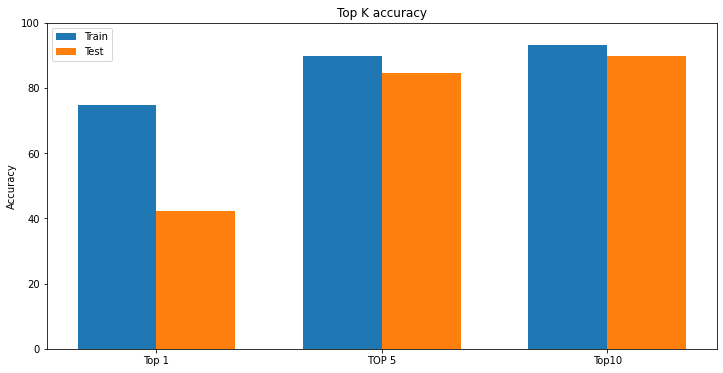

In [178]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, train_acc, width, label='Train')
ax.bar(x + width/2, test_acc, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Top K accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.ylim(0,100)
plt.show()

In [179]:
pca = PCA(n_components=2, whiten=True)  
pca.fit(np.vstack([X, Y]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())



Variance explained: 0.10


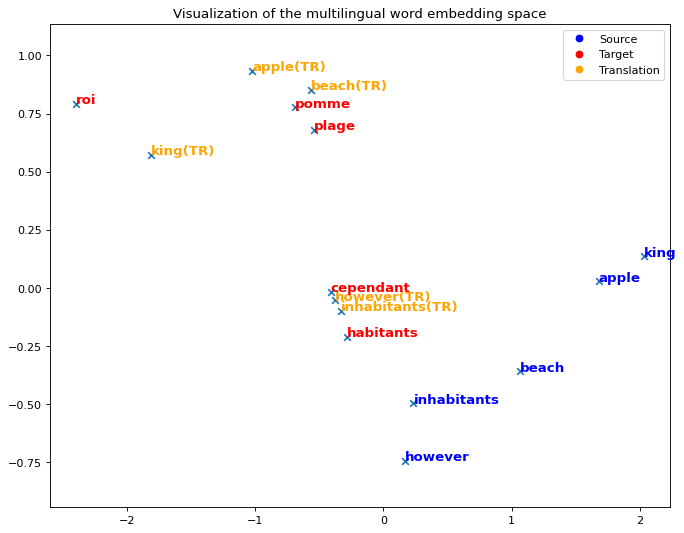

In [180]:

src_words = ['apple','beach','king','inhabitants',  u'however']
tgt_words = ['pomme','plage','roi', 'habitants', 'cependant']



plot_similar_word(svd_trans_en_fr, src_words, en_dict, tgt_words, fr_dict, pca)